In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import tqdm

In [ ]:
#TODO: Extract ERA5 data by loading in 3d convective diagnostic array. This could be done programatically, 
# before saving and analysing here. Could probably also add lightning data from grid in same script.

def load_tint_aws(fid, loc_id, y):
    #Read the AWS-TINT output, which contains one-minute gusts merged with the closest TINT storm UID, 
    # as well as a flag for if the storm is within 0, 10 or 20 km
    df = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+fid+"_aws.csv")
    df["hour_floor"] = pd.DatetimeIndex(df.dt_utc).floor("1H")
    df["day"] = pd.DatetimeIndex(df.dt_utc).floor("D")

    #Get the severe convective gusts. Defined when there is an object within 10 km, 
    # the gust is greater than 25 m/s. Only interested in the unique "events", defined
    # by having a unique storm id. However, because the storm can change ID on short time 
    # scales, also constrain events to unique days.
    scws = df.query("in10km==1").query("gust>=25").sort_values("gust",ascending=False).\
        drop_duplicates("uid10").drop_duplicates("day").sort_values("dt_utc")

    #Read the storm object statistics from TINT. Merge with the SCW events, and classify
    storm2 = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+fid+".csv")
    scws = scws.merge(storm2, left_on=["uid10","scan"], right_on=["uid","scan"])
    scws = scws[["dt_utc","stn_id","hour_floor","scan","gust","major_axis_length","minor_axis_length","local_max","azi_shear","max_alt","conv_pct","num_of_scans"]]
    if scws.shape[0]>0:
        scws["aspect"] = scws["major_axis_length"] / scws["minor_axis_length"]
        scws.loc[(scws["major_axis_length"]>=100) & (scws["aspect"]>=3),"class"] = "Linear"
        scws.loc[(scws["major_axis_length"]>=100) & (scws["aspect"]<3),"class"] = "Non-linear"
        scws.loc[(scws["major_axis_length"]<100) & (scws["local_max"]==1),"class"] = "Cellular"
        scws.loc[(scws["major_axis_length"]<100) & (scws["local_max"]>1),"class"] = "Cell cluster"
        scws.loc[(scws["major_axis_length"]<100) & (scws["aspect"]<3) & (scws["azi_shear"]>=4.5),"class"] = "Supercellular"
        scws.loc[(scws["max_alt"]<8) & (scws["conv_pct"]<0.5),"class"] = "Shallow"

        era5 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/era5_rad50km_case_study_"+str(y)+"_"+str(y)+"_max.pkl")
        scws = scws.merge(era5[era5.loc_id==loc_id], right_on="time", left_on="hour_floor")

    return df, scws
 
def last_day_of_month(any_day):
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - dt.timedelta(days=next_month.day)    


scws2 = pd.DataFrame()
scws66 = pd.DataFrame()
scws71 = pd.DataFrame()
for y in tqdm.tqdm(np.arange(2000,2021)):
    for m in np.arange(1,13):
        fid1 = dt.datetime(y,m,1).strftime("%Y%m%d")
        fid2 = last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")        
        try:
            temp_all, temp = load_tint_aws("2_"+fid1+"_"+fid2, "Melbourne", y)
            scws2 = pd.concat([scws2, temp],axis=0,sort=False)
        except:
            pass
        try:
            temp_all, temp = load_tint_aws("66_"+fid1+"_"+fid2, "Amberley", y)
            scws66 = pd.concat([scws66, temp],axis=0,sort=False)
        except:
            pass        
        try:
            temp_all, temp = load_tint_aws("71_"+fid1+"_"+fid2, "Sydney", y)
            scws71 = pd.concat([scws71, temp],axis=0,sort=False)
        except:
            pass                


100%|██████████| 21/21 [14:22<00:00, 41.09s/it]


In [ ]:
import joblib
wrf_mod = joblib.load('/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/cluster_model_era5.pkl')
df_norm = (scws2[["s06","qmean01","lr13","Umean06"]]\
           - scws2[["s06","qmean01","lr13","Umean06"]].min(axis=0))\
    / (scws2[["s06","qmean01","lr13","Umean06"]].max(axis=0) - \
       scws2[["s06","qmean01","lr13","Umean06"]].min(axis=0))
scws2["cluster"] = wrf_mod.predict(df_norm)
print(scws2.cluster.value_counts())

df_norm = (scws66[["s06","qmean01","lr13","Umean06"]]\
           - scws66[["s06","qmean01","lr13","Umean06"]].min(axis=0))\
    / (scws66[["s06","qmean01","lr13","Umean06"]].max(axis=0) - \
       scws66[["s06","qmean01","lr13","Umean06"]].min(axis=0))
scws66["cluster"] = wrf_mod.predict(df_norm)
print(scws66.cluster.value_counts())

df_norm = (scws71[["s06","qmean01","lr13","Umean06"]]\
           - scws71[["s06","qmean01","lr13","Umean06"]].min(axis=0))\
    / (scws71[["s06","qmean01","lr13","Umean06"]].max(axis=0) - \
       scws71[["s06","qmean01","lr13","Umean06"]].min(axis=0))
scws71["cluster"] = wrf_mod.predict(df_norm)
print(scws71.cluster.value_counts())

0    90
2    67
1    33
Name: cluster, dtype: int64
1    56
0    25
2    17
Name: cluster, dtype: int64
1    63
0    30
2    20
Name: cluster, dtype: int64


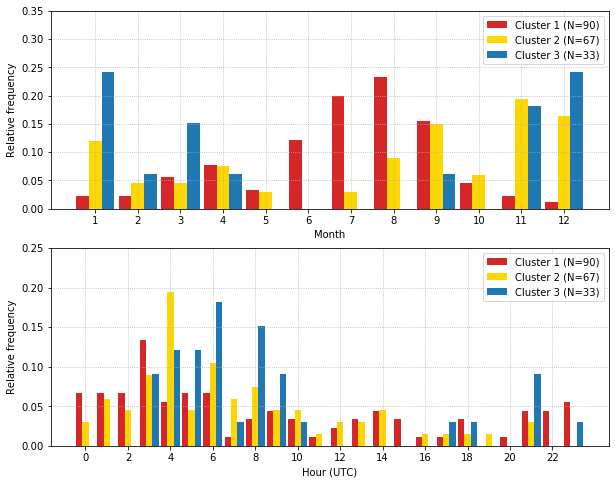

In [ ]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)

cond1="cluster==0"
cond2="cluster==2"
cond3="cluster==1"

months = pd.DatetimeIndex(scws2.query(cond1).dt_utc).month.value_counts().sort_index()
plt.bar(months.index-0.3, months / months.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws2.query(cond1).shape[0])+")")

months = pd.DatetimeIndex(scws2.query(cond2).dt_utc).month.value_counts().sort_index()
plt.bar(months.index, months / months.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws2.query(cond2).shape[0])+")")

months = pd.DatetimeIndex(scws2.query(cond3).dt_utc).month.value_counts().sort_index()
plt.bar(months.index+0.3, months / months.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws2.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(1,13))
plt.legend()
plt.ylim([0,0.35])
plt.gca().grid(ls=":")
plt.xlabel("Month")
plt.ylabel("Relative frequency")

plt.subplot(2,1,2)

hours = pd.DatetimeIndex(scws2.query(cond1).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index-0.3, hours / hours.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws2.query(cond1).shape[0])+")")

hours = pd.DatetimeIndex(scws2.query(cond2).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index, hours / hours.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws2.query(cond2).shape[0])+")")

hours = pd.DatetimeIndex(scws2.query(cond3).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index+0.3, hours / hours.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws2.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(0,24,2))
plt.legend()
plt.ylim([0,0.25])
plt.gca().grid(ls=":")
plt.xlabel("Hour (UTC)")
plt.ylabel("Relative frequency")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scw_tint_frequency_melb.jpeg",quality=100,bbox_inches="tight")

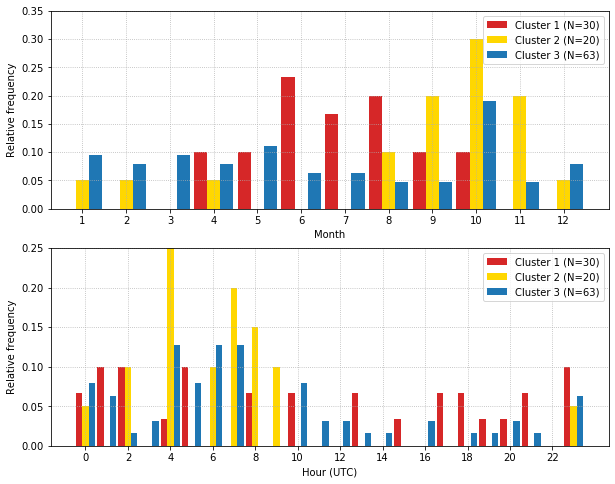

In [ ]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)

cond1="cluster==0"
cond2="cluster==2"
cond3="cluster==1"

months = pd.DatetimeIndex(scws71.query(cond1).dt_utc).month.value_counts().sort_index()
plt.bar(months.index-0.3, months / months.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws71.query(cond1).shape[0])+")")

months = pd.DatetimeIndex(scws71.query(cond2).dt_utc).month.value_counts().sort_index()
plt.bar(months.index, months / months.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws71.query(cond2).shape[0])+")")

months = pd.DatetimeIndex(scws71.query(cond3).dt_utc).month.value_counts().sort_index()
plt.bar(months.index+0.3, months / months.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws71.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(1,13))
plt.legend()
plt.ylim([0,0.35])
plt.gca().grid(ls=":")
plt.xlabel("Month")
plt.ylabel("Relative frequency")

plt.subplot(2,1,2)

hours = pd.DatetimeIndex(scws71.query(cond1).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index-0.3, hours / hours.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws71.query(cond1).shape[0])+")")

hours = pd.DatetimeIndex(scws71.query(cond2).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index, hours / hours.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws71.query(cond2).shape[0])+")")

hours = pd.DatetimeIndex(scws71.query(cond3).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index+0.3, hours / hours.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws71.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(0,24,2))
plt.legend()
plt.ylim([0,0.25])
plt.gca().grid(ls=":")
plt.xlabel("Hour (UTC)")
plt.ylabel("Relative frequency")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scw_tint_frequency_syd.jpeg",quality=100,bbox_inches="tight")

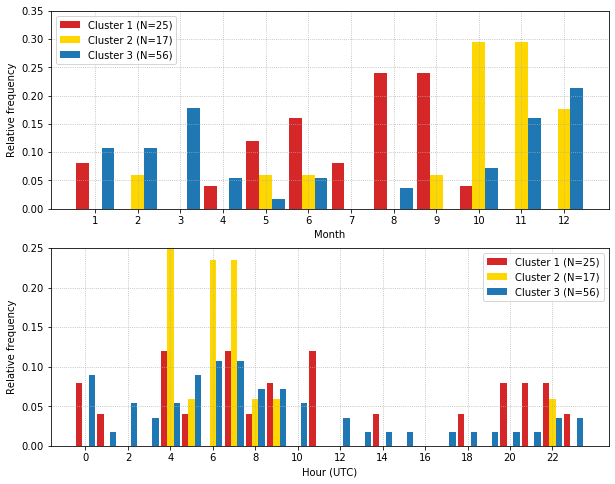

In [ ]:
plt.figure(figsize=[10,8])
plt.subplot(2,1,1)

cond1="cluster==0"
cond2="cluster==2"
cond3="cluster==1"

months = pd.DatetimeIndex(scws66.query(cond1).dt_utc).month.value_counts().sort_index()
plt.bar(months.index-0.3, months / months.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws66.query(cond1).shape[0])+")")

months = pd.DatetimeIndex(scws66.query(cond2).dt_utc).month.value_counts().sort_index()
plt.bar(months.index, months / months.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws66.query(cond2).shape[0])+")")

months = pd.DatetimeIndex(scws66.query(cond3).dt_utc).month.value_counts().sort_index()
plt.bar(months.index+0.3, months / months.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws66.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(1,13))
plt.legend()
plt.ylim([0,0.35])
plt.gca().grid(ls=":")
plt.xlabel("Month")
plt.ylabel("Relative frequency")

plt.subplot(2,1,2)

hours = pd.DatetimeIndex(scws66.query(cond1).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index-0.3, hours / hours.sum(),color="tab:red",width=0.3,label="Cluster 1 (N="+str(scws66.query(cond1).shape[0])+")")

hours = pd.DatetimeIndex(scws66.query(cond2).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index, hours / hours.sum(),color="gold",width=0.3,label="Cluster 2 (N="+str(scws66.query(cond2).shape[0])+")")

hours = pd.DatetimeIndex(scws66.query(cond3).dt_utc).hour.value_counts().sort_index()
plt.bar(hours.index+0.3, hours / hours.sum(),color="tab:blue",width=0.3,label="Cluster 3 (N="+str(scws66.query(cond3).shape[0])+")")


_=plt.xticks(ticks=np.arange(0,24,2))
plt.legend()
plt.ylim([0,0.25])
plt.gca().grid(ls=":")
plt.xlabel("Hour (UTC)")
plt.ylabel("Relative frequency")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scw_tint_frequency_bris.jpeg",quality=100,bbox_inches="tight")

In [53]:
print(scws2.query(cond1).shape[0],scws2.query(cond2).shape[0],scws2.query(cond3).shape[0])
print(scws2.query(cond1).shape[0] + scws2.query(cond2).shape[0] + scws2.query(cond3).shape[0])
scws2.shape

136 48 32
216


(216, 23)

(0.0, 2000.0)

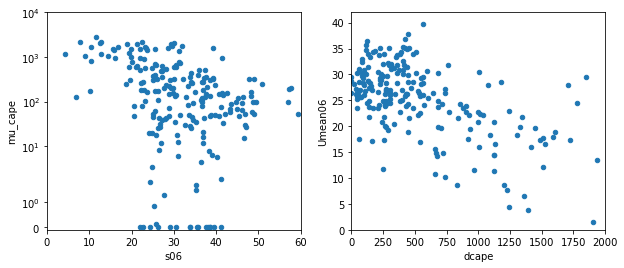

In [58]:
plt.figure(figsize=[10,4])
ax=plt.subplot(1,2,1)
scws2.plot(kind="scatter",x="s06",y="mu_cape",ax=ax); plt.yscale("symlog"); plt.ylim([-.1,10000]); plt.xlim([0,60])
ax=plt.subplot(1,2,2)
scws2.plot(kind="scatter",x="dcape",y="Umean06",ax=ax); plt.ylim([0,42]); plt.xlim([0,2000])

(0.0, 2000.0)

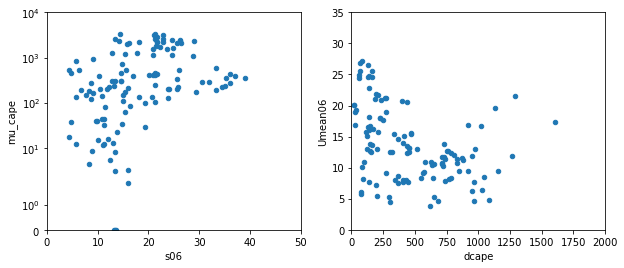

In [63]:
plt.figure(figsize=[10,4])
ax=plt.subplot(1,2,1)
scws66.plot(kind="scatter",x="s06",y="mu_cape",ax=ax); plt.yscale("symlog"); plt.ylim([0,10000]); plt.xlim([0,50])
ax=plt.subplot(1,2,2)
scws66.plot(kind="scatter",x="dcape",y="Umean06",ax=ax); plt.ylim([0,35]); plt.xlim([0,2000])

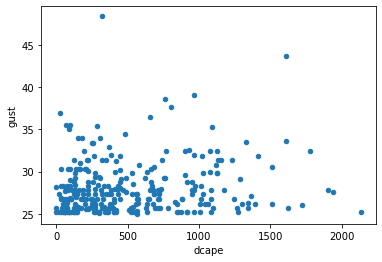

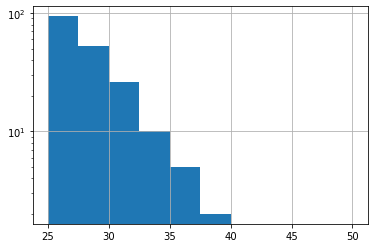

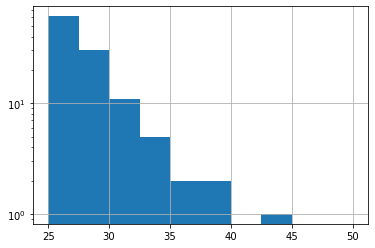

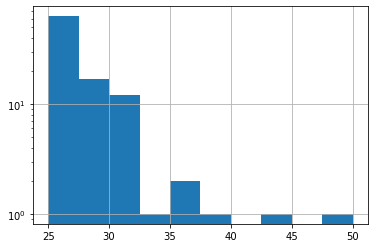

In [31]:
scws2.gust.hist(range=[25,60],log=True,bins=np.arange(25,52.5,2.5))
plt.figure()
scws71.gust.hist(range=[25,60],log=True,bins=np.arange(25,52.5,2.5))
plt.figure()
scws66.gust.hist(range=[25,60],log=True,bins=np.arange(25,52.5,2.5))

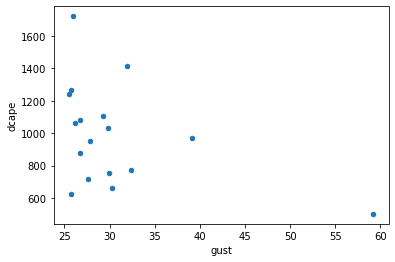

In [67]:
temp=pd.concat([scws2,scws71,scws66],axis=0)
temp=temp[temp["class"]=="Supercellular"]
temp.plot(kind="scatter",x="gust",y="dcape")

Text(0.5, 0.98, 'Melbourne 2005-2020')

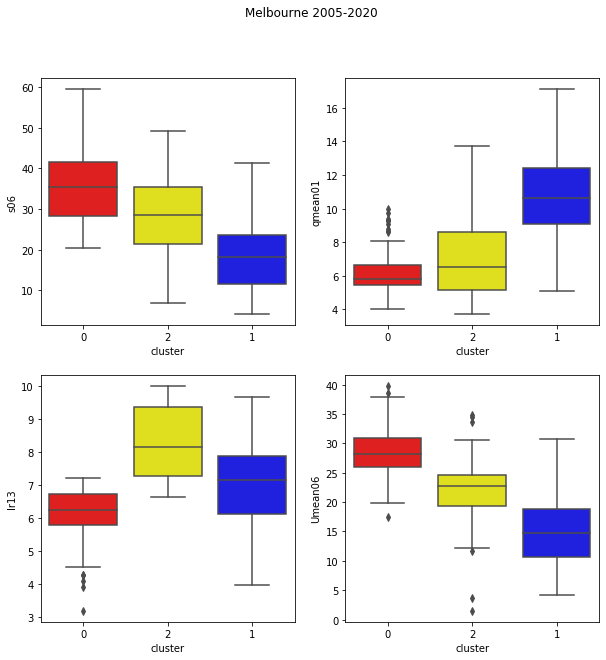

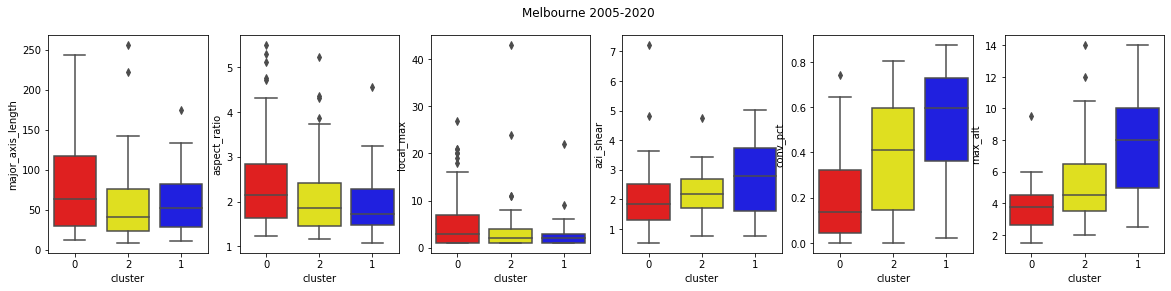

In [48]:
plt.figure(figsize=[10,10])

import seaborn as sns
plt.subplot(2,2,1)
sns.boxplot(data=scws2,x="cluster",y="s06",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,2)
sns.boxplot(data=scws2,x="cluster",y="qmean01",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,3)
sns.boxplot(data=scws2,x="cluster",y="lr13",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,4)
sns.boxplot(data=scws2,x="cluster",y="Umean06",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Melbourne 2005-2020")

scws2["aspect_ratio"]=scws2["major_axis_length"]/scws2["minor_axis_length"]
plt.figure(figsize=[20,4])
plt.subplot(1,6,1)
sns.boxplot(data=scws2,x="cluster",y="major_axis_length",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,2)
sns.boxplot(data=scws2,x="cluster",y="aspect_ratio",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,3)
sns.boxplot(data=scws2,x="cluster",y="local_max",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,4)
sns.boxplot(data=scws2,x="cluster",y="azi_shear",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,5)
sns.boxplot(data=scws2,x="cluster",y="conv_pct",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,6)
sns.boxplot(data=scws2,x="cluster",y="max_alt",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Melbourne 2005-2020")


Text(0.5, 0.98, 'Brisbane 2005-2020')

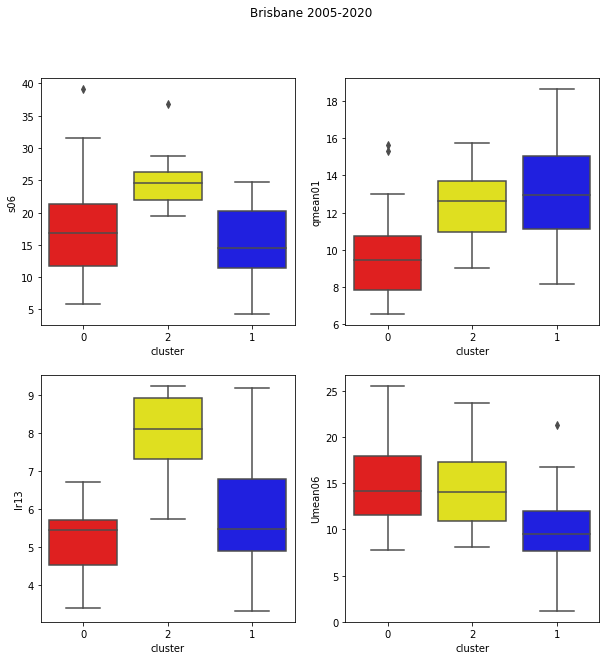

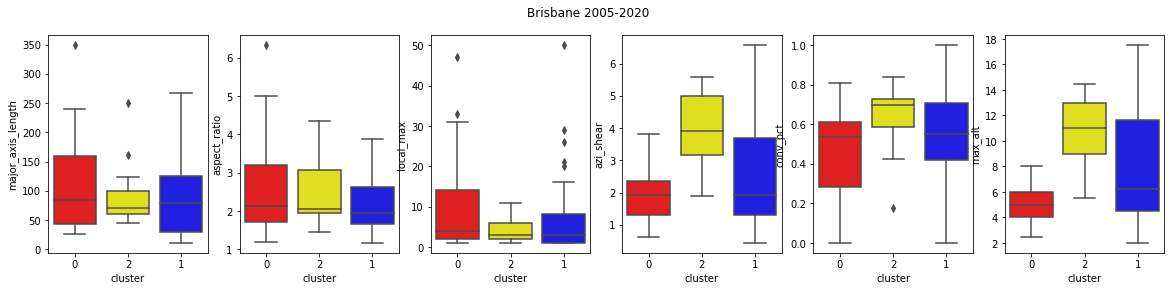

In [50]:
plt.figure(figsize=[10,10])

import seaborn as sns
plt.subplot(2,2,1)
sns.boxplot(data=scws66,x="cluster",y="s06",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,2)
sns.boxplot(data=scws66,x="cluster",y="qmean01",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,3)
sns.boxplot(data=scws66,x="cluster",y="lr13",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,4)
sns.boxplot(data=scws66,x="cluster",y="Umean06",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Brisbane 2005-2020")

scws66["aspect_ratio"]=scws66["major_axis_length"]/scws66["minor_axis_length"]
plt.figure(figsize=[20,4])
plt.subplot(1,6,1)
sns.boxplot(data=scws66,x="cluster",y="major_axis_length",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,2)
sns.boxplot(data=scws66,x="cluster",y="aspect_ratio",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,3)
sns.boxplot(data=scws66,x="cluster",y="local_max",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,4)
sns.boxplot(data=scws66,x="cluster",y="azi_shear",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,5)
sns.boxplot(data=scws66,x="cluster",y="conv_pct",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,6)
sns.boxplot(data=scws66,x="cluster",y="max_alt",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Brisbane 2005-2020")


Text(0.5, 0.98, 'Sydney 2005-2020')

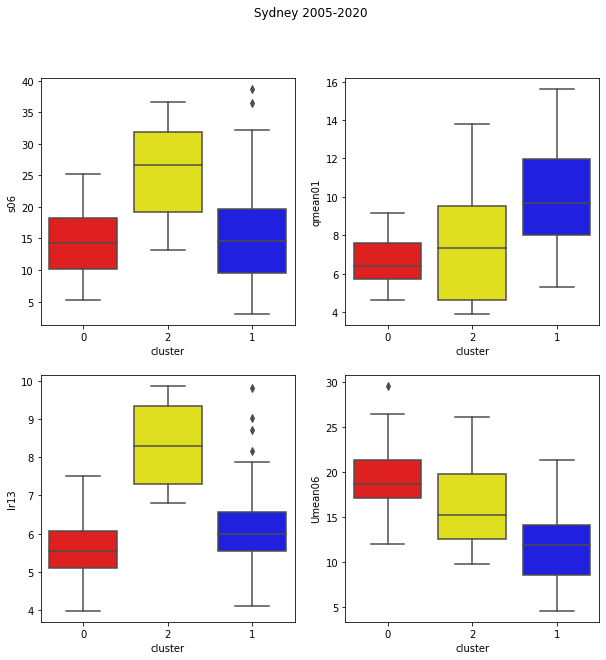

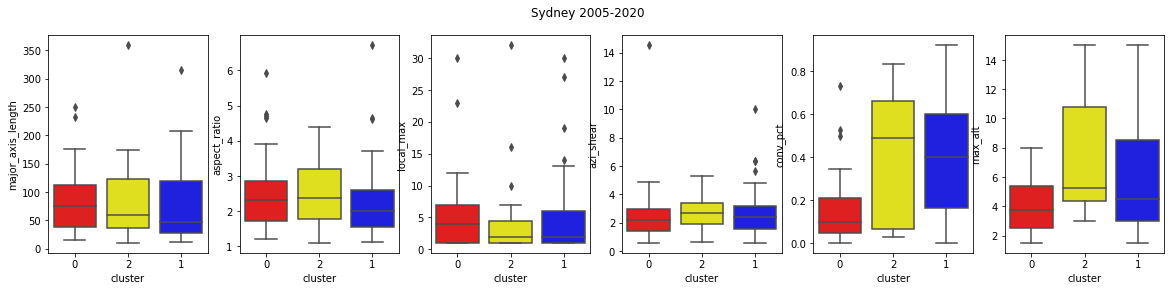

In [52]:
plt.figure(figsize=[10,10])

import seaborn as sns
plt.subplot(2,2,1)
sns.boxplot(data=scws71,x="cluster",y="s06",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,2)
sns.boxplot(data=scws71,x="cluster",y="qmean01",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,3)
sns.boxplot(data=scws71,x="cluster",y="lr13",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(2,2,4)
sns.boxplot(data=scws71,x="cluster",y="Umean06",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Sydney 2005-2020")

scws71["aspect_ratio"]=scws71["major_axis_length"]/scws71["minor_axis_length"]
plt.figure(figsize=[20,4])
plt.subplot(1,6,1)
sns.boxplot(data=scws71,x="cluster",y="major_axis_length",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,2)
sns.boxplot(data=scws71,x="cluster",y="aspect_ratio",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,3)
sns.boxplot(data=scws71,x="cluster",y="local_max",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,4)
sns.boxplot(data=scws71,x="cluster",y="azi_shear",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,5)
sns.boxplot(data=scws71,x="cluster",y="conv_pct",order=[0,2,1],palette=["red","yellow","blue"])
plt.subplot(1,6,6)
sns.boxplot(data=scws71,x="cluster",y="max_alt",order=[0,2,1],palette=["red","yellow","blue"])
plt.suptitle("Sydney 2005-2020")
